### 问题的提出

1. 如果训练数据只分为1个训练集。那么模型即使发生了过拟合却不自知
2. 故将测试数据分为了训练集和测试集。通过测试集判断模型好坏。缺点是：有可能模型针对特定测试集发生了过拟合。
3. 较好的办法：将整个数据划分为3份。
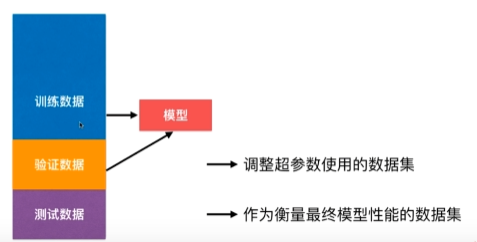
4. 上述方法仍有问题：即每次验证集都是从整体数据集中随机切分出来的。训练的模型有可能过拟合验证集。一旦验证集中有比较极端的数据，就可能导致模型预测不准确。
5. 解决方案：交叉验证
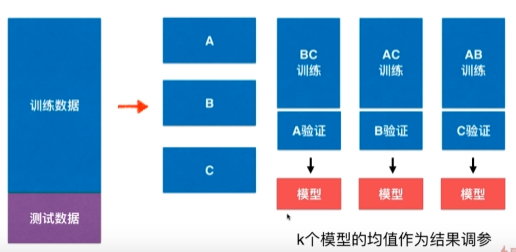

In [1]:
import numpy as np
from sklearn import datasets

In [2]:
digits = datasets.load_digits()
X = digits.data
y = digits.target

### 测试train_test_split

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=666)

In [4]:
from sklearn.neighbors import KNeighborsClassifier

best_k, best_p, best_score = 0, 0, 0
for k in range(2, 11):
    for p in range(1, 6):
        knn_clf = KNeighborsClassifier(weights="distance", n_neighbors=k, p=p)
        knn_clf.fit(X_train, y_train)
        score = knn_clf.score(X_test, y_test)
        if score > best_score:
            best_k, best_p, best_score = k, p, score
            
print("Best K =", best_k)
print("Best P =", best_p)
print("Best Score =", best_score)

Best K = 3
Best P = 2
Best Score = 0.9860917941585535


### 使用交叉验证

In [5]:
from sklearn.model_selection import cross_val_score

knn_clf = KNeighborsClassifier()
cross_val_score(knn_clf, X_train, y_train)  # 交叉验证
# CV默认训练了5个模型，每个模型的评分如下：

array([0.99537037, 0.98148148, 0.97685185, 0.97674419, 0.97209302])

In [6]:
# 使用交叉验证的方式获取KNN的最佳超参数
best_k, best_p, best_score = 0, 0, 0
for k in range(2, 11):
    for p in range(1, 6):
        knn_clf = KNeighborsClassifier(weights="distance", n_neighbors=k, p=p)
        scores = cross_val_score(knn_clf, X_train, y_train)
        score = np.mean(scores)
        if score > best_score:
            best_k, best_p, best_score = k, p, score
            
print("Best K =", best_k)
print("Best P =", best_p)
print("Best Score =", best_score)

# 可以发现K，P和train_test_split所得到不一样。并且score也较小。但我们还是较相信交叉验证
# 所得到的最佳超参数。因为train_test_split可能会对测试集发生过拟合。

Best K = 2
Best P = 2
Best Score = 0.9851507321274763


In [7]:
# 使用最佳的模型来进行测试
best_knn_clf = KNeighborsClassifier(weights="distance", n_neighbors=2, p=2)
best_knn_clf.fit(X_train, y_train)
best_knn_clf.score(X_test, y_test)

0.980528511821975

### 网格搜索，包含了利用交叉验证寻找最佳超参数的过程

In [8]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'weights': ['distance'],
        'n_neighbors': [i for i in range(2, 11)],  # 9种
        'p': [i for i in range(1, 6)]  # 5种
    }
]

grid_search = GridSearchCV(knn_clf, param_grid, verbose=1)
grid_search.fit(X_train, y_train)

# 有9 * 5种参数组合，每种参数组合都用5个模型进行训练。总共训练了225个模型。

Fitting 5 folds for each of 45 candidates, totalling 225 fits


GridSearchCV(estimator=KNeighborsClassifier(n_neighbors=10, p=5,
                                            weights='distance'),
             param_grid=[{'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                          'p': [1, 2, 3, 4, 5], 'weights': ['distance']}],
             verbose=1)

In [9]:
grid_search.best_score_

0.9851507321274763

In [10]:
grid_search.best_params_

{'n_neighbors': 2, 'p': 2, 'weights': 'distance'}

In [11]:
best_knn_clf = grid_search.best_estimator_
best_knn_clf.score(X_test, y_test)

0.980528511821975

### 调整每次训练模型的个数

In [12]:
cross_val_score(knn_clf, X_train, y_train, cv=3) # 每次训练3个模型

array([0.98055556, 0.98050139, 0.96100279])

In [14]:
grid_search = GridSearchCV(knn_clf, param_grid, verbose=1, cv=5) # 每次训练3个模型

### K-folds 交叉验证

把训练数据集分成k份。每次训练k个模型，相当于整体性能慢了k倍

### 留一法

训练数据集含m个样本，把训练数据集分成m份，称为留一法。
优点：完全不受随机的影响，最接近模型真正的性能指标。
缺点：计算量巨大